In [274]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [275]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [276]:
folder = os.listdir()

file = []
for f in folder:
    if "jinju_all" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

jinju_all = pd.concat(file)
# jinju_all = jinju_all.dropna(axis=0)

jinju_all

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명
0,경상남도 진주시 가좌동,1***,25m미만,12.00,월세,201902,16,200,35,2016.0,가좌길74번길
1,경상남도 진주시 가좌동,1***,8m미만,12.00,전세,201901,5,"4,500",0,2016.0,가좌길78번길
2,경상남도 진주시 가좌동,1***,-,12.88,월세,201912,11,"4,500",7,1989.0,NaN
3,경상남도 진주시 가좌동,1***,-,12.88,월세,201912,18,"4,500",7,1989.0,NaN
4,경상남도 진주시 가좌동,1***,8m미만,14.20,월세,201906,25,300,32,2016.0,가좌길60번길
...,...,...,...,...,...,...,...,...,...,...,...
3568,경상남도 진주시 호탄동,6**,8m미만,99.00,월세,202203,14,300,50,2003.0,호탄길27번길
3569,경상남도 진주시 호탄동,6**,8m미만,100.00,월세,202202,13,500,50,2003.0,호탄길14번길
3570,경상남도 진주시 호탄동,6**,8m미만,106.76,전세,202205,6,"14,000",0,2018.0,호탄길9번길
3571,경상남도 진주시 호탄동,6**,25m미만,107.76,월세,202210,19,"9,000",10,2004.0,호탄길


In [277]:
folder = os.listdir()

file = []
for f in folder:
    if "gajwa" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)
    
gajwa = pd.concat(file)
gajwa = gajwa.dropna(axis=0)

In [278]:
folder = os.listdir()

file = []
for f in folder:
    if "hotan" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

hotan = pd.concat(file)
# hotan = gajwa.dropna(axis=0)

In [279]:
gajwa.도로조건.value_counts()

12m미만    1039
8m미만      621
-         610
25m미만     120
25m이상      43
Name: 도로조건, dtype: int64

In [280]:
geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

# gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
# gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})
# gajwa = gajwa.fillna({'도로조건':gajwa['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "8"
    if a=="25m이상":
        a = "30"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)

# covid = []
# for c in gajwa.year:
#     if c in [2020, 2021]:
#         covid.append(1)
#     else:
#         covid.append(0)
# gajwa["coivd"] = covid

gajwa["price_per_m2"] = gajwa.전세전환가격 / gajwa["계약면적(㎡)"]**2

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,58.576389
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,39.610471
3,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,11.718750
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,15.432099
5,경상남도 진주시 가좌동,1***,12,18.00,전세,201902,24,5000,0,2019,가좌길36번길,128.102026,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,15.432099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,경상남도 진주시 가좌동,1***,12,40.00,월세,201711,8,5000,10,2006,진주대로404번길,128.106121,35.158214,2017,11,경상남도 진주시 가좌동 진주대로404번길,5.0,7400,4.625000
2423,경상남도 진주시 가좌동,4**,12,50.00,월세,201711,23,7000,10,2011,진주대로568번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 진주대로568번길,5.0,9400,3.760000
2424,경상남도 진주시 가좌동,1***,8,80.00,전세,201711,9,14000,0,2016,가좌길78번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 가좌길78번길,5.0,14000,2.187500
2425,경상남도 진주시 가좌동,1***,12,84.69,월세,201711,13,700,60,1990,가좌길48번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 가좌길48번길,5.0,15100,2.105294


In [281]:
geo = pd.read_csv("./geocoding.csv")
hotan["경도"] = geo.X
hotan["위도"] = geo.Y

hotan = hotan.fillna({'건축년도':hotan['건축년도'].mode()[0]})
hotan = hotan.fillna({'도로명':hotan['도로명'].mode()[0]})
hotan = hotan.fillna({'도로조건':hotan['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in hotan["도로조건"]:
    if a=="-":
        a = "8"
    if a=="25m이상":
        a = "30"
    road.append(int(a.split("m")[0]))
hotan["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in hotan["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

hotan["year"] = year
hotan["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in hotan["건축년도"]]
hotan["건축년도"] = built_day

# 위치 column만들기
hotan["location"] = hotan.시군구 + " " + hotan.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

hotan = pd.merge(left=hotan, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in hotan["보증금(만원)"]]
hotan["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(hotan["월세(만원)"][i] * 12 / (hotan["전월세전환율"][i]/100) + hotan["보증금(만원)"][i]) for i in range(len(hotan))]
hotan["전세전환가격"] = value
#hotan["도로별 전세값평균"] = hotan.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(hotan["도로명"])):
    if "번길" not in hotan["도로명"][i]:
        indexNames.append(i)

hotan.drop(indexNames, inplace=True)


hotan

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격
0,경상남도 진주시 호탄동,6**,8,15.00,전세,201402,11,3000,0,2001,호탄길22번길,128.105889,35.157466,2014,2,경상남도 진주시 호탄동 호탄길22번길,7.1,3000
1,경상남도 진주시 호탄동,6**,8,16.22,월세,201402,18,1780,5,1999,호탄길22번길,128.105889,35.157466,2014,2,경상남도 진주시 호탄동 호탄길22번길,7.1,2625
3,경상남도 진주시 호탄동,6**,8,23.10,월세,201402,26,1000,22,2006,호탄길22번길,128.107551,35.152434,2014,2,경상남도 진주시 호탄동 호탄길22번길,7.1,4718
4,경상남도 진주시 호탄동,9**,8,23.14,전세,201402,22,5000,0,2011,강변길10번길,128.106188,35.158872,2014,2,경상남도 진주시 호탄동 강변길10번길,7.1,5000
5,경상남도 진주시 호탄동,6**,12,24.00,월세,201402,9,1000,20,2001,호탄길21번길,128.106121,35.158214,2014,2,경상남도 진주시 호탄동 호탄길21번길,7.1,4380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,경상남도 진주시 호탄동,6**,8,33.00,전세,201904,9,4000,0,2005,호탄길28번길,128.099898,35.158679,2019,4,경상남도 진주시 호탄동 호탄길28번길,5.3,4000
2083,경상남도 진주시 호탄동,6**,8,50.00,월세,201904,24,7000,5,2012,호탄길34번길,128.117325,35.163883,2019,4,경상남도 진주시 호탄동 호탄길34번길,5.3,8132
2084,경상남도 진주시 호탄동,6**,25,52.00,월세,201904,7,2000,23,2004,호탄길22번길,128.103328,35.145290,2019,4,경상남도 진주시 호탄동 호탄길22번길,5.3,7208
2085,경상남도 진주시 호탄동,6**,8,65.00,전세,201904,17,7000,0,2017,호탄길34번길,128.112879,35.163589,2019,4,경상남도 진주시 호탄동 호탄길34번길,5.3,7000


In [282]:
print(gajwa.전세전환가격.mean())
gajwa[gajwa.전월세구분 == "월세"].전세전환가격.mean()

7416.082714214958


8132.140706806283

In [283]:
print(hotan.전세전환가격.mean())
hotan[hotan.전월세구분 == "월세"].전세전환가격.mean()

7395.324134199134


8102.296546546547

## 지도

In [284]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [285]:
gnu_lat = 35.1530444
gnu_long = 128.1010899

gnu_dist = []
for long, lat in zip(gajwa["경도"], gajwa["위도"]):
    d = distance(gnu_lat, lat, gnu_long, long)
    gnu_dist.append(d)
gajwa["gnu_distance"] = gnu_dist

## 데이터 시각화

In [286]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},)

In [287]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.7)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

gajwa = remove_out(gajwa, ["계약면적(㎡)", "전세전환가격", "gnu_distance"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2,gnu_distance
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,58.576389,0.657356
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,39.610471,0.734594
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,11.718750,0.796668
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,15.432099,0.796668
4,경상남도 진주시 가좌동,1***,12,18.00,전세,201902,24,5000,0,2019,가좌길36번길,128.102026,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,15.432099,0.440456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,경상남도 진주시 가좌동,4**,12,35.20,월세,201807,12,800,50,2006,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,13300,10.734117,0.434847
1588,경상남도 진주시 가좌동,4**,12,25.00,전세,201711,29,4000,0,2009,개양로6번길,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 개양로6번길,5.0,4000,6.400000,0.885957
1589,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,250,30,1987,가좌길60번길,128.108839,35.155111,2017,11,경상남도 진주시 가좌동 가좌길60번길,5.0,7450,8.277778,0.741008
1590,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,300,38,2012,가좌길29번길,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 가좌길29번길,5.0,9420,10.466667,0.885957


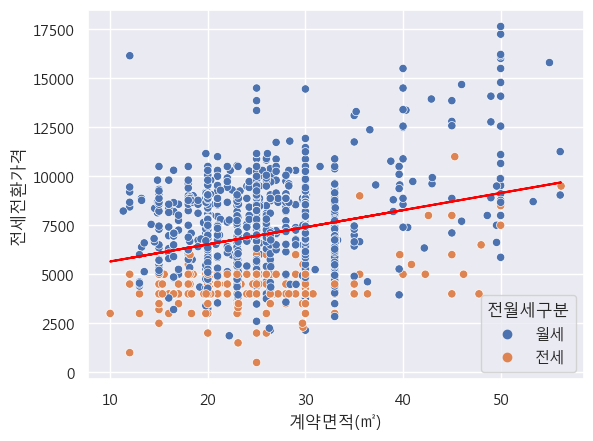

In [288]:
sns.scatterplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격", hue = "전월세구분")
# sns.lmplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격")
m, b = np.polyfit(gajwa["계약면적(㎡)"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약면적(㎡)"], m * gajwa["계약면적(㎡)"] + b, color = "red")
plt.show()

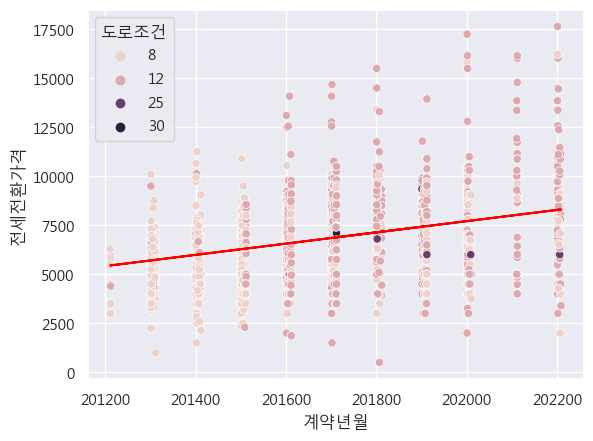

In [289]:
sns.scatterplot(data = gajwa, x = "계약년월", y = "전세전환가격", hue = "도로조건")
m, b = np.polyfit(gajwa["계약년월"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약년월"], m * gajwa["계약년월"] + b, color = "red")
plt.show()

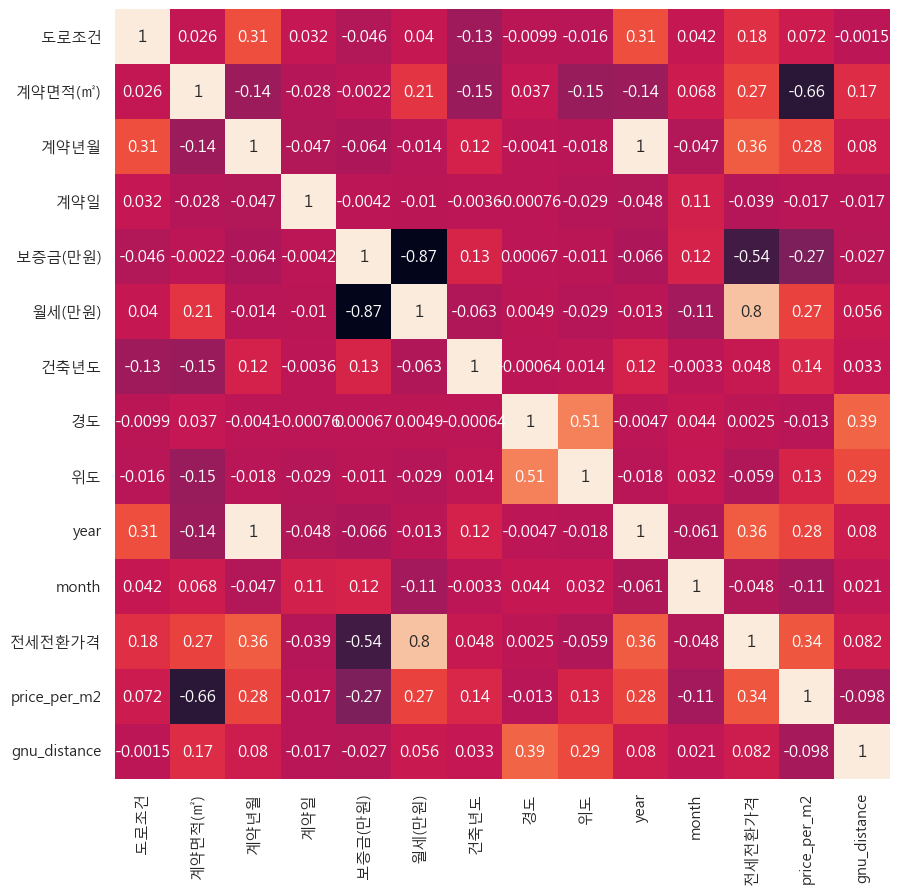

In [290]:
corr = gajwa.corr()

plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, cbar = False)
plt.show()

In [291]:
area = []

for long, lat in zip(gajwa["경도"],gajwa["위도"]) :
    if 128.102554 < long < 128.107094 and 35.155823 < lat < 35.162156 :
        area.append('후문')
    elif 128.107502 < long < 128.116019 and 35.155877 < lat < 35.158884 :
        area.append('경찰서')
    elif 128.105510 < long < 128.109887 and 35.152340 < lat <35.155835 :
        area.append('정문')
    elif 128.099328 < long < 128.105970 and 35.14718 < lat < 35.151686 :
        area.append('남문')
    elif 128.102356 < long < 128.118509 and 35.161807 < lat < 35.166844 :
        area.append('호탄')
    elif 128.107524 < long < 128.118378 and 35.159442 < lat < 35.161644 :
        area.append('호탄')
    else :
        area.append('그 외')

gajwa["area"] = area
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,...,경도,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2,gnu_distance,area
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,...,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,58.576389,0.657356,후문
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,...,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,39.610471,0.734594,후문
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,...,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,11.718750,0.796668,후문
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,...,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,15.432099,0.796668,후문
4,경상남도 진주시 가좌동,1***,12,18.00,전세,201902,24,5000,0,2019,...,128.102026,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,15.432099,0.440456,남문
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,경상남도 진주시 가좌동,4**,12,35.20,월세,201807,12,800,50,2006,...,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,13300,10.734117,0.434847,남문
1588,경상남도 진주시 가좌동,4**,12,25.00,전세,201711,29,4000,0,2009,...,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 개양로6번길,5.0,4000,6.400000,0.885957,그 외
1589,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,250,30,1987,...,128.108839,35.155111,2017,11,경상남도 진주시 가좌동 가좌길60번길,5.0,7450,8.277778,0.741008,정문
1590,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,300,38,2012,...,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 가좌길29번길,5.0,9420,10.466667,0.885957,그 외


In [292]:
# import folium

# m = folium.Map(location=[gnu_lat, gnu_long], zoom_start=14)

# for lo, la, in zip(gajwa.경도, gajwa.위도):
#     folium.Marker([la, lo]).add_to(m)

# m

In [293]:
# m = folium.Map(location=[gajwa.위도.max(),gajwa.경도.min()], zoom_start=16)
# folium.Marker([gajwa.위도.max(),gajwa.경도.min()]).add_to(m)
# m

In [294]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)

#원핫인코딩
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분", "도로명"])


gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,경도,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
0,경상남도 진주시 가좌동,1***,25,12.00,201902,16,200,35,2016,128.105889,...,0,0,0,0,0,0,0,0,0,0
1,경상남도 진주시 가좌동,1***,12,14.85,201902,20,500,35,2019,128.106121,...,0,0,0,0,0,0,0,0,0,0
2,경상남도 진주시 가좌동,1***,8,16.00,201902,20,3000,0,2016,128.106188,...,0,0,0,0,0,0,0,0,0,0
3,경상남도 진주시 가좌동,1***,8,18.00,201902,20,5000,0,2016,128.106188,...,0,0,0,0,0,0,0,0,0,0
4,경상남도 진주시 가좌동,1***,12,18.00,201902,24,5000,0,2019,128.102026,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,경상남도 진주시 가좌동,4**,12,35.20,201807,12,800,50,2006,128.104882,...,0,0,0,0,0,0,0,0,0,0
1588,경상남도 진주시 가좌동,4**,12,25.00,201711,29,4000,0,2009,128.103328,...,0,0,0,0,0,0,0,0,0,0
1589,경상남도 진주시 가좌동,1***,8,30.00,201711,26,250,30,1987,128.108839,...,0,0,0,0,0,0,0,0,0,0
1590,경상남도 진주시 가좌동,1***,8,30.00,201711,26,300,38,2012,128.103328,...,0,0,0,0,0,0,0,0,0,0


In [295]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "계약일", "보증금(만원)", "월세(만원)", "location", "경도", "위도", "전월세전환율", "gnu_distance"], axis=1)

#gajwa_data.distance = gajwa_data.distance.transform(lambda x: (x - x.mean()) / x.std())
#gajwa_data.전세전환가격 = gajwa_data.전세전환가격.transform(lambda x: (x - x.mean()) / x.std())
gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,price_per_m2,gnu_distance,전월세구분_월세,전월세구분_전세,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
0,25,12.00,2016,2019,2,8435,58.576389,0.657356,1,0,...,0,0,0,0,0,0,0,0,0,0
1,12,14.85,2019,2019,2,8735,39.610471,0.734594,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8,16.00,2016,2019,2,3000,11.718750,0.796668,0,1,...,0,0,0,0,0,0,0,0,0,0
3,8,18.00,2016,2019,2,5000,15.432099,0.796668,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,18.00,2019,2019,2,5000,15.432099,0.440456,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,12,35.20,2006,2018,7,13300,10.734117,0.434847,1,0,...,0,0,0,0,0,0,0,0,0,0
1588,12,25.00,2009,2017,11,4000,6.400000,0.885957,0,1,...,0,0,0,0,0,0,0,0,0,0
1589,8,30.00,1987,2017,11,7450,8.277778,0.741008,1,0,...,0,0,0,0,0,0,0,0,0,0
1590,8,30.00,2012,2017,11,9420,10.466667,0.885957,1,0,...,0,0,0,0,0,0,0,0,0,0


# 머신러닝

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [297]:
from sklearn.model_selection import train_test_split

# X = gajwa_data.drop(["전세전환가격"], axis=1)
# y = gajwa_data['전세전환가격']

gajwa_data = gajwa_data.drop(["전세전환가격"], axis=1)
X = gajwa_data.drop(["price_per_m2"], axis=1)
y = gajwa_data['price_per_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

# scaler = StandardScaler()
# X_train_standardized = scaler.fit_transform(X_train)
# X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [298]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [299]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [300]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [301]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [302]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [303]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

0.8356493974556974


In [304]:
# gbm = GradientBoostingRegressor()

# gbm.fit(X_train, y_train)
# print(gbm.score(X_test, y_test))

# gbm.fit(X_train_standardized, y_train)
# print(gbm.score(X_test_standardized, y_test))

## LightGBM

In [305]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# lightgbm.fit(X_train_standardized, y_train)
# print(lightgbm.score(X_test_standardized, y_test))

0.8567954996644787

## XGBoost

In [306]:
xgboost = XGBRegressor(n_estimators=50)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

# xgboost.fit(X_train_standardized, y_train)
# xgboost.score(X_test_standardized, y_test)

0.8580904084607872


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



## CatBoost

In [307]:
# cb = catboost.CatBoostRegressor()
# cb.fit(X_train_standardized, y_train)
# cb.score(X_test_standardized, y_test)

In [308]:
gajwa_data.corr()

,도로조건,계약면적(㎡),건축년도,year,month,price_per_m2,gnu_distance,전월세구분_월세,전월세구분_전세,도로명_가좌길29번길,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
도로조건,1.000000,0.026158,-0.132544,0.309967,0.041554,0.071634,-0.001467,0.012657,-0.012657,-0.141010,...,-0.056768,0.085898,-0.035491,0.080298,0.019543,0.029195,0.061986,-0.092910,0.013802,0.027046
계약면적(㎡),0.026158,1.000000,-0.148706,-0.141884,0.067760,-0.660715,0.170542,0.085896,-0.085896,-0.020803,...,0.036650,0.110833,-0.016156,0.096537,-0.080961,0.073944,0.151404,0.055639,0.112697,0.045776
건축년도,-0.132544,-0.148706,1.000000,0.116138,-0.003314,0.142030,0.032697,-0.108761,0.108761,0.063615,...,0.051131,-0.030526,0.058152,-0.044289,-0.032134,0.002266,-0.008285,0.011462,-0.197946,0.061367
year,0.309967,-0.141884,0.116138,1.000000,-0.060966,0.277295,0.079569,-0.003137,0.003137,-0.047348,...,-0.018746,0.021769,-0.138793,-0.032704,-0.092275,-0.029326,-0.015810,-0.021480,0.015978,0.055737
month,0.041554,0.067760,-0.003314,-0.060966,1.000000,-0.109591,0.021125,-0.066272,0.066272,0.035498,...,0.060265,0.022629,-0.048650,-0.018930,0.038271,0.056016,0.078667,0.000734,-0.029685,0.056574
price_per_m2,0.071634,-0.660715,0.142030,0.277295,-0.109591,1.000000,-0.098025,0.261422,-0.261422,-0.003332,...,-0.022866,-0.025817,-0.169700,0.004254,0.065420,-0.049227,-0.060125,-0.039408,-0.049630,-0.042299
gnu_distance,-0.001467,0.170542,0.032697,0.079569,0.021125,-0.098025,1.000000,0.006066,-0.006066,-0.023805,...,-0.013608,0.016205,0.025893,-0.003178,-0.033819,0.026332,0.058721,0.004791,0.022808,-0.006166
전월세구분_월세,0.012657,0.085896,-0.108761,-0.003137,-0.066272,0.261422,0.006066,1.000000,-1.000000,0.015118,...,0.006232,0.084682,-0.149605,0.153536,0.038485,0.057590,0.062687,0.052994,-0.032750,0.023530
전월세구분_전세,-0.012657,-0.085896,0.108761,0.003137,0.066272,-0.261422,-0.006066,-1.000000,1.000000,-0.015118,...,-0.006232,-0.084682,0.149605,-0.153536,-0.038485,-0.057590,-0.062687,-0.052994,0.032750,-0.023530
도로명_가좌길29번길,-0.141010,-0.020803,0.063615,-0.047348,0.035498,-0.003332,-0.023805,0.015118,-0.015118,1.000000,...,-0.017921,-0.028735,-0.070050,-0.066428,-0.013059,-0.031697,-0.035086,-0.022248,-0.009222,-0.007984


## HyperParameter

In [309]:
import optuna
from optuna.samplers import TPESampler

# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    # Generate model
    lgbm = lgb.LGBMRegressor(**param)
    lgbm = lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
                           verbose=0, early_stopping_rounds=25)

    # xgboost = XGBRegressor(**param)
    # xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
    #                        verbose=0, early_stopping_rounds=25)


    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    # MSE = mean_squared_error(y_test, lgbm.predict(X_test))
    # return MSE
    # rmse = mean_squared_error(y_test, lgbm.predict(X_test), squared=False)
    rmse = mean_squared_error(y_test, lgbm.predict(X_test), squared=False)
    return rmse

    # r2 = r2_score(y_test, lgbm.predict(X_test)
    # return r2

study = optuna.create_study(direction='minimize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
study.optimize(objective, n_trials=100)

[I 2022-12-04 19:03:44,667] A new study created in memory with name: no-name-201b914f-5f06-4bf1-94bc-04ff4a7b6a74
/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_15974/4179727320.py:15: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_15974/4179727320.py:16: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_15974/4179727320.py:17: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_flo

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 6.0336386413981495,
params {'num_leaves': 8, 'colsample_bytree': 0.8074945112738847, 'reg_alpha': 0.8305810332683214, 'reg_lambda': 9.431544398267327, 'max_depth': 3, 'learning_rate': 0.009869837204867277, 'n_estimators': 1766, 'min_child_samples': 5, 'subsample': 0.492733024813016}


In [ ]:
final_model = lgb.LGBMRegressor(**trial_params)
# final_model = XGBRegressor(**trial_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.3781814675696221

0.67 : 도로조건	계약면적(㎡)	건축년도	year	month	전세전환가격	전월세구분_월세	전월세구분_전세

0.716 : 도로조건	계약면적(㎡)	건축년도	year	month	전세전환가격	전월세구분_월세	전월세구분_전세	도로명_가좌길29번길

0.73 : 결측치 다 drop / 도로조건	계약면적(㎡)	건축년도	year	month	전세전환가격	전월세구분_월세	전월세구분_전세	도로명_가좌길29번길

0.766

## 딥러닝

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# model = Sequential()
# model.add(Dense(128, activation='relu', input_dim=38))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
# model.fit(X_train, y_train, epochs=7000, batch_size=50)

In [ ]:
# y_pred = model.predict(X_test).flatten()
# r2 = r2_score(y_test, y_pred)
# r2